In [2]:
# On importe les librairies dont on a besoin
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn import decomposition
from sklearn import preprocessing

In [ ]:
# Fonction qui renvoie une liste de couleur à partir du dataFrame, de la colonne à traiter
# et d'un dictionnaire contenant les valeurs et les couleurs à appliquer
#Ex: Utilisé pour visualiser le nutriscore par couleur
def pltcolor(unDataFrame, uneVariable, unDict):
    cols=[]
    for uneCategorie in unDataFrame[uneVariable]:
        if uneVariable == 'nutrition-score-fr_100g':
            cols.append(unDict[getNutriscore(uneCategorie)])
        else:
            cols.append(unDict[uneCategorie])
    return cols

In [10]:
# on charge le fichier dans un dataFrame
data = pd.read_csv("fr.openfoodfacts.org.products.nettoye.csv",decimal=".", low_memory=False)

In [12]:
# dictionnaire lettre/couleur pour le nutriscore
nutri_color_dict = {}
nutri_color_dict['A'] = 'darkgreen'
nutri_color_dict['B'] = 'limegreen'
nutri_color_dict['C'] = 'yellow'
nutri_color_dict['D'] = 'orange'
nutri_color_dict['E'] = 'red'

Mettre le camembert avec la répartition des produits par pays : au survol nombre de produits ou fair eun histogramme poru afficher plus de pays.
selecteur du pays
afficher le nutriscore par catégorie
afficher le nutriscore par marque
projeter les produits sur les 2 axes de l'acp
filtrer sur un produit en particulier ?
zoomer sur le nuage de point de l'acp ?

Select(description='Catégorie:', index=6, options=('non renseignée', 'Chocolats', 'Aliments et boissons à base…

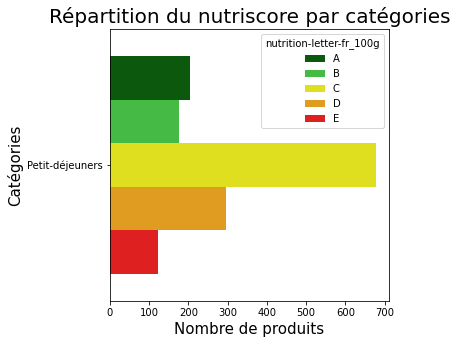

In [13]:
def categorie_onclick(ma_value):
    plt.figure(figsize=(5, 5))
    sns.countplot(y="main_category_fr", hue="nutrition-letter-fr_100g",hue_order=["A", "B","C","D","E"], data=data[data['main_category_fr']==ma_value], palette=nutri_color_dict);

categorie_select = widgets.Select(
    options=data['main_category_fr'].value_counts().index,
    value='Conserves',
    # rows=10,
    description='Catégorie:',
    disabled=False
)
display(categorie_select)

def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(categorie_select)
        plt.figure(figsize=(5, 5))
        histo_cat_nutri = sns.countplot(y="main_category_fr", hue="nutrition-letter-fr_100g",hue_order=["A", "B","C","D","E"], data=data[data['main_category_fr']==change['new']], palette=nutri_color_dict)
        histo_cat_nutri.set_ylabel('Catégories', fontsize = 15)
        histo_cat_nutri.set_xlabel('Nombre de produits', fontsize = 15)
        histo_cat_nutri.set_title('Répartition du nutriscore par catégories', fontsize = 20)

categorie_onclick('Conserves')
categorie_select.observe(on_change)